In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime

In [3]:
θ = np.load('theta2.npy')
tols = np.load('tols2.npy')

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


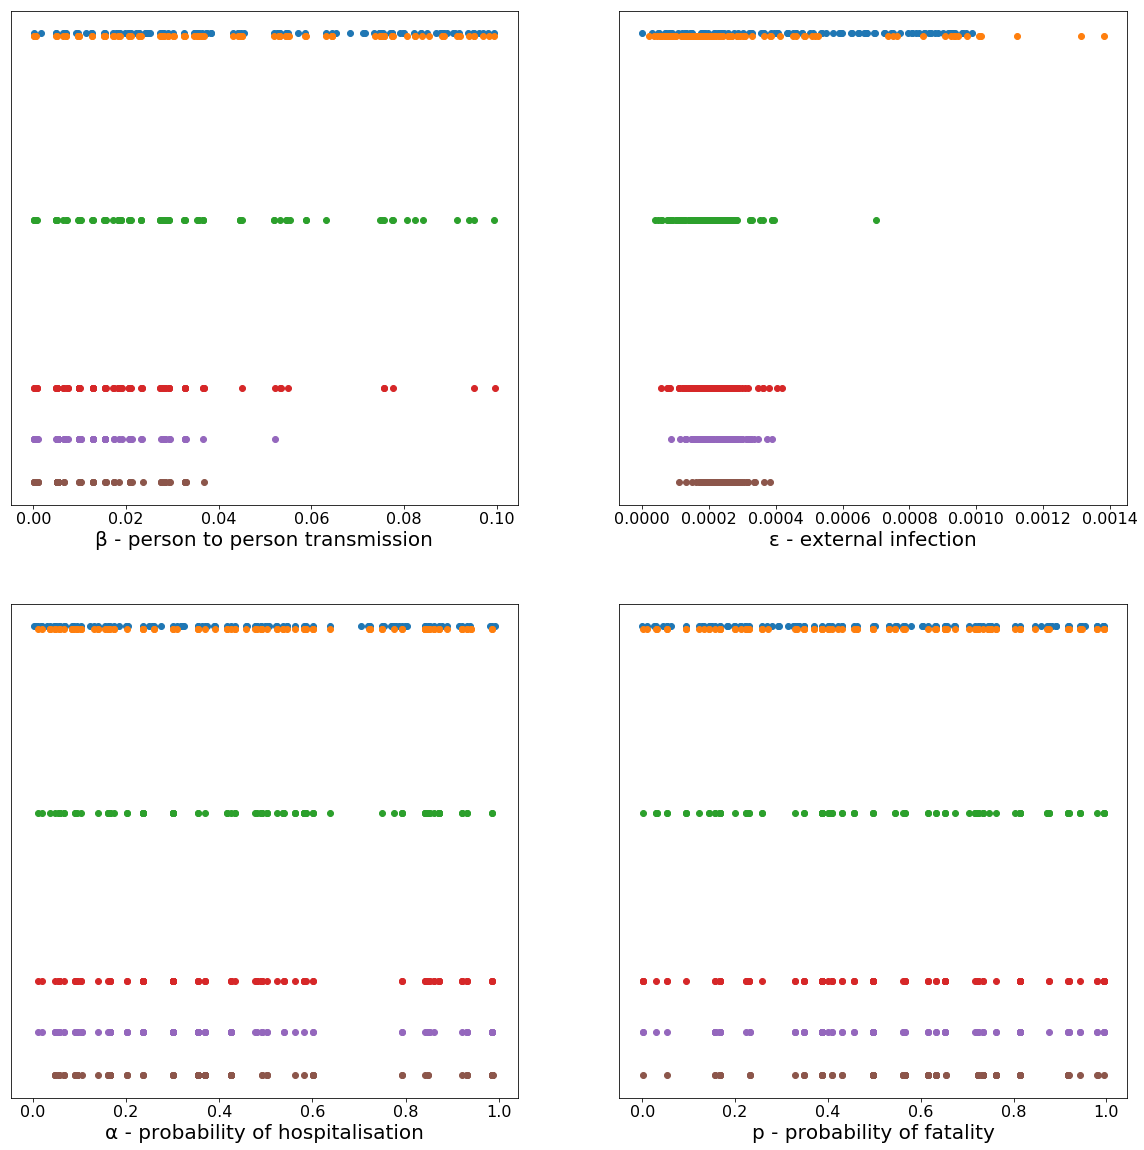

In [4]:
plt.figure(figsize = (20,20))
# tol = 6
for i in range(6):
    plt.subplot(2,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(100), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(2,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(100), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,3)
    plt.plot(θ[i][:,2], tols[i]*np.ones(100), 'o' )
    plt.xlabel('α - probability of hospitalisation', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,4)
    plt.plot(θ[i][:,3], tols[i]*np.ones(100), 'o' )
    plt.xlabel('p - probability of fatality', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)


/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'ɛ')

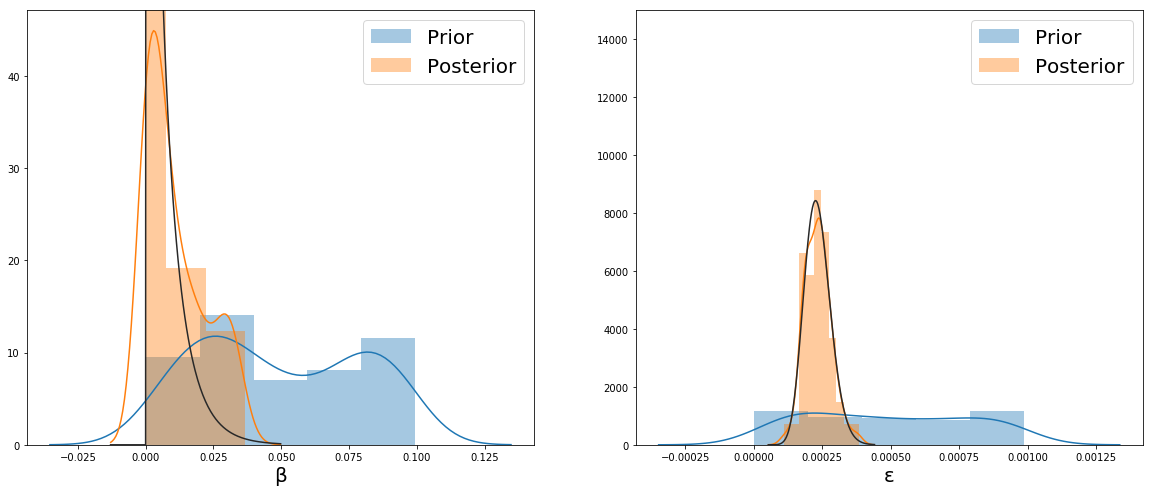

In [10]:
from scipy import stats
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.legend(fontsize = 20)
# plt.ylim([0, 100])
# plt.xlim([0,0.15])
plt.xlabel('β', fontsize = 20)

plt.subplot(1,2,2)
sns.distplot(θ[0][:,1], kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,1], kde=True,  fit=stats.gamma,  norm_hist=False, label = 'Posterior')
plt.legend(fontsize = 20)
plt.ylim([0, 15000])

plt.xlabel('ɛ', fontsize = 20)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'p')

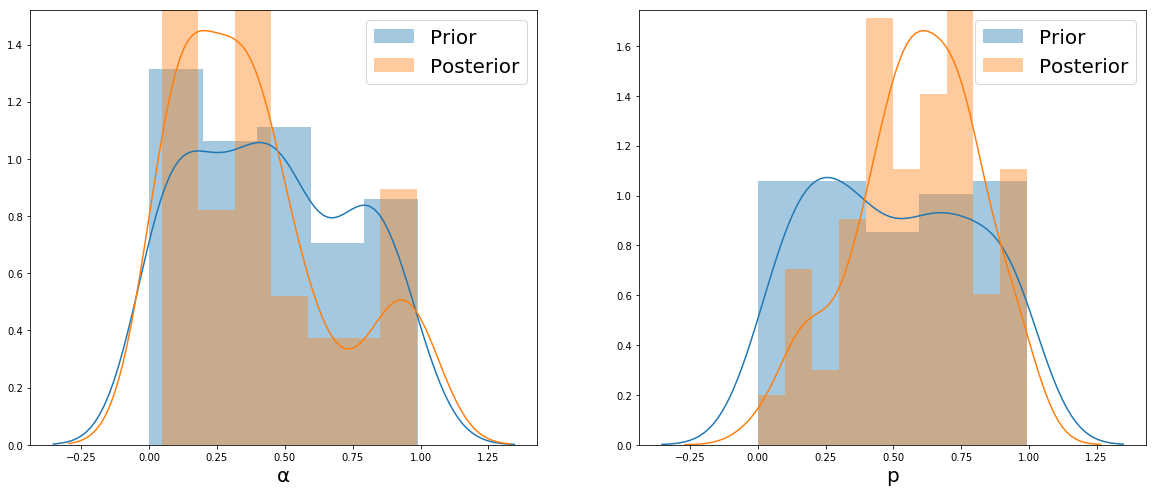

In [7]:
from scipy import stats
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.distplot(θ[0][:,2],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,2],  kde=True,  norm_hist=False,  label = 'Posterior')
plt.legend(fontsize = 20)
# plt.ylim([0, 100])
# plt.xlim([0,0.15])
plt.xlabel('α', fontsize = 20)

plt.subplot(1,2,2)
sns.distplot(θ[0][:,3], kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,3], kde=True,  norm_hist=False, label = 'Posterior')
plt.legend(fontsize = 20)
# plt.ylim([0, 15000])

plt.xlabel('p', fontsize = 20)

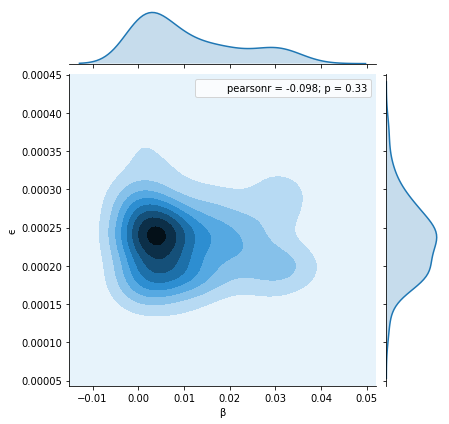

In [8]:
d = {'β': θ[5][:,0], 'ϵ': θ[5][:,1], 'α': θ[5][:,2], 'p': θ[5][:,3]}
df = pd.DataFrame(data = d)
sns.jointplot(x="β", y="ϵ", data=df, kind="kde");

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/emma/.local/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


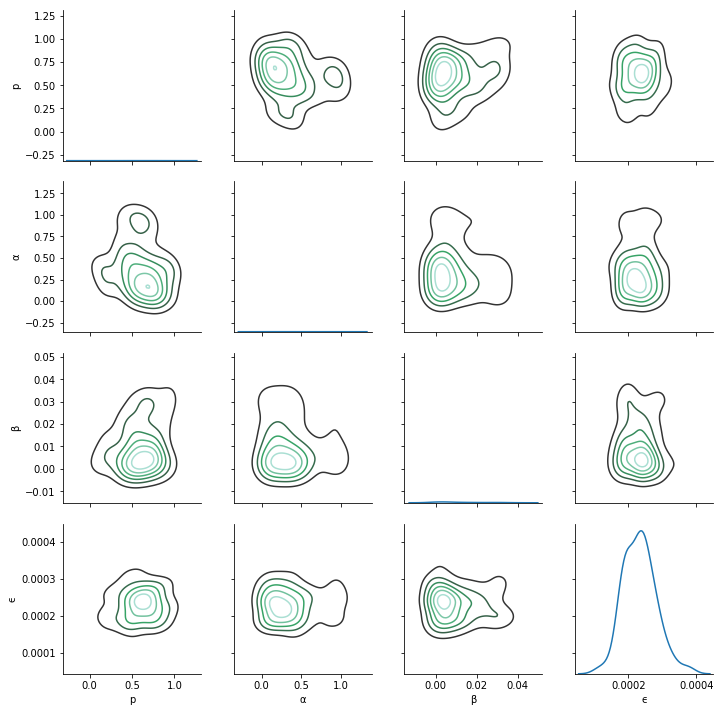

In [9]:
g = sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [13]:
#####################################################################################
############################### DATASETS ############################################
#####################################################################################

Data_F04=pd.read_csv("../Case_data/2004_F_cases.csv",sep = ',', header = 0)
############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days) 
#     record = [int(a - record[0]) for a in record]
    return record

Rec_F04=Spacing(Data_F04)

In [65]:
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
capT = 10000
α = 1/2
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]

In [66]:
def gillespieSEIHR(initial, beta, mu1,mu2, sigma, omega, alpha, epsilon, mort,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        

        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])
    return event_time, np.array(pop), events, cuminf

In [67]:
parameters = [Input_H, μ1, μ2, σ, ω, α, capT]
r_β = np.random.randint(0, 99)
r_ϵ = np.random.randint(0,99)
r_α = np.random.randint(0,99)
r_p = np.random.randint(0,99)
r = np.random.randint(0,99)
betas = θ[5][:,0]
eps = θ[5][:,1]
alphas = θ[5][:,2]
pps = θ[5][:,3]
parameters[6]


10000

In [68]:
timing = []
cumulative = []
for k in range(200):
    r_β = np.random.randint(0, 99)
    r_ϵ = np.random.randint(0,99)
    r_α = np.random.randint(0,99)
    r_p = np.random.randint(0,99)
    M =gillespieSEIHR(parameters[0], betas[r_β], parameters[1],parameters[2],
                          parameters[3], parameters[4], alphas[r_α],eps[r_ϵ],pps[r_p],  parameters[6])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
    #     print(max_inf, max_time, βt, ɛt)


    summary_time = Rec_F04
    #         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = Data_F04['CumsumInf'].values
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 1)
        summary_time = np.append(summary_time, length1)
    #         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max( Data_F04['CumsumInf'].values)*np.ones(len(length1 )))
    #         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    timing.append(inter_t)
    cumulative.append(inter_cum)
    #         print(summary_time, summary_cum)
    print(np.linalg.norm(summary_cum-inter_cum[summary_time]),  betas[r_β],alphas[r_α],eps[r_ϵ],pps[r_p])

2458.1570332263154 0.005082448353329487 0.8423669977383238 0.0002668537444839024 0.6166130375063859
87.19518335321051 0.005082448353329487 0.30057815183806424 0.00014883527679477226 0.38693837302693634
349.01719155365396 0.005043602549782114 0.06760801952058795 0.0002875466772075913 0.7349070430724554
1193.3201582140478 0.005042337105584135 0.0896148006789151 0.0002668537444839024 0.3865170422200744
99.55400544428134 0.005100046727901214 0.16091790933659592 0.00017504515396847897 0.4300999812492441
7560.548657339625 0.015525192336972011 0.6014498402215196 0.00026571238606965685 0.5617295001477141
7272.878591039452 0.032669956852937984 0.30070126941316155 0.00028619087957207633 0.49697143657680815
200.7112353606544 0.009955375928497686 0.2014200070584801 0.00023635606398675905 0.7628761349773714
9630.389400226763 0.0005595100379693215 0.4244160866081754 0.0002383668869121627 0.7629545301606586
3596.3099143427557 0.009885678215629608 0.42446894430589804 0.00023250334667092356 0.496552652

KeyboardInterrupt: 

In [61]:
maxi = []
for k in range(200):
    maxi.append(max(timing[k]))
summary_cum = Data_F04['CumsumInf'].values
if max(maxi)> max(Rec_F04):
        length1 =  np.arange(max(Rec_F04), max(maxi) +1, 1)
        summary_time = np.append(Rec_F04, length1)
    #         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max( Data_F04['CumsumInf'].values)*np.ones(len(length1 )))

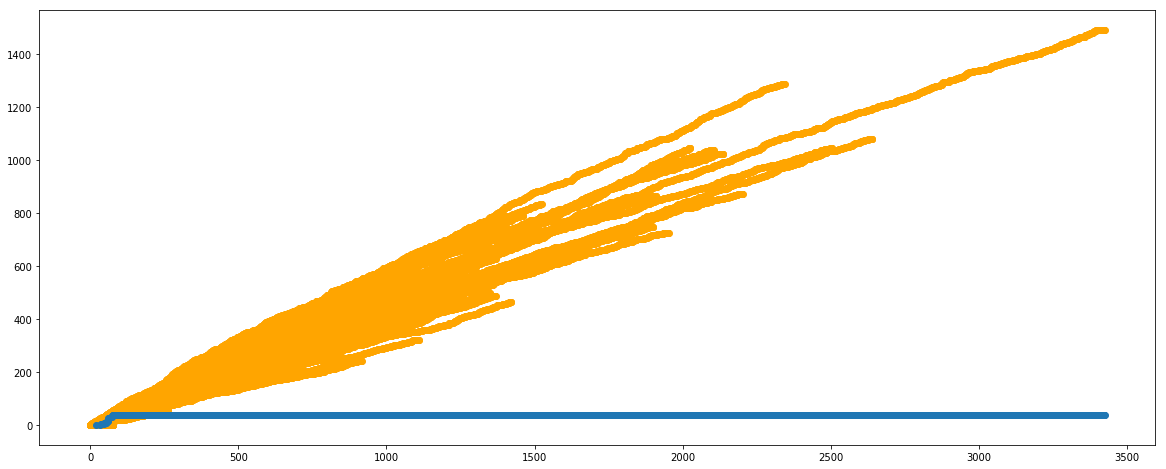

In [64]:
plt.figure(figsize = (20,8))
for j in range(200):
    plt.plot(timing[j], cumulative[j], 'o', color = 'orange')
plt.plot(summary_time, summary_cum, 'o')
# plt.xlim([0,400])

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


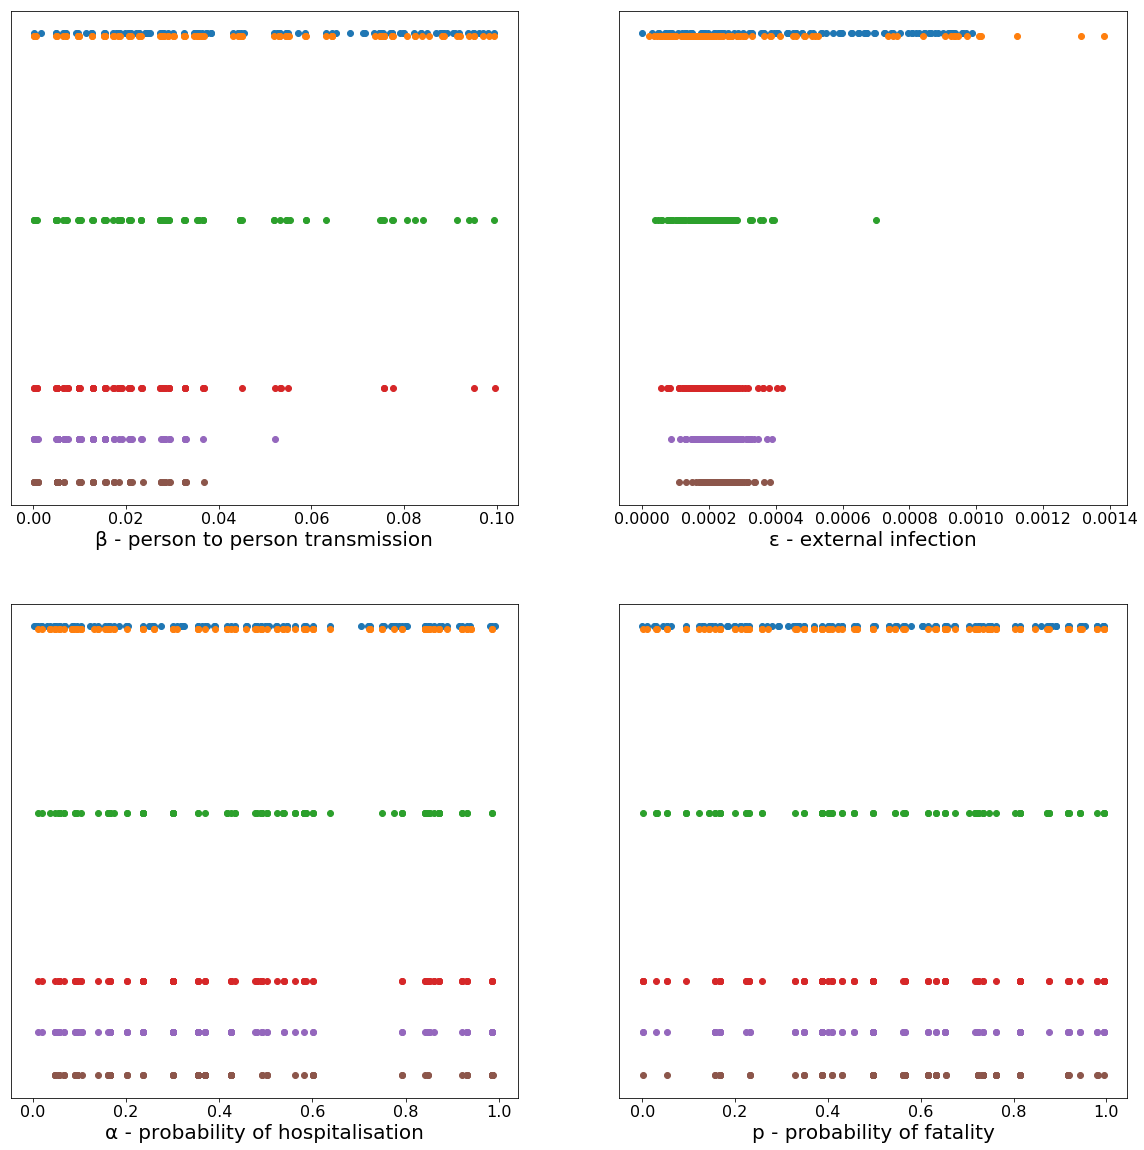

In [69]:
plt.figure(figsize = (20,20))
# tol = 6
for i in range(6):
    plt.subplot(2,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(100), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(2,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(100), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,3)
    plt.plot(θ[i][:,2], tols[i]*np.ones(100), 'o' )
    plt.xlabel('α - probability of hospitalisation', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,4)
    plt.plot(θ[i][:,3], tols[i]*np.ones(100), 'o' )
    plt.xlabel('p - probability of fatality', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)